# Setup

In [112]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [123]:
import fastai
import torch
fastai.__version__, torch.__version__

('1.0.48', '1.0.1.post2')

In [71]:
data_path = Path('./data')
data_path.absolute(), data_path.exists()

(PosixPath('/home/intsco/Dropbox/ML/off_sample/classification/data'), True)

In [72]:
path_label_df = pd.read_csv(data_path / 'path_label.csv')
path_label_df.head()

,path,label
0,data/test/Hvpo379 3718#1 #5.2/off/C20H32O3+H.png,off
1,data/test/Hvpo379 3718#1 #5.2/off/C18H34O3+Na.png,off
2,data/test/Hvpo379 3718#1 #5.2/off/C17H22N4O+Na...,off
3,data/test/Hvpo379 3718#1 #5.2/off/C16H26O5+Na.png,off
4,data/test/Hvpo379 3718#1 #5.2/on/C15H32O6+Na.png,on


In [107]:
labels = (path_label_df.label == 'off').astype(int).values

In [108]:
pd.value_counts(labels)

1    837
0    823
dtype: int64

# Predict from Folder

In [124]:
import sklearn
from pathlib import Path

In [125]:
from fastai.vision.data import ImageList

In [126]:
from fastai import *
from fastai.vision import *

In [127]:
test_input_path = data_path / 'test'
test_input_path

PosixPath('data/test')

In [129]:
# test_item_list = ImageItemList.from_folder(test_path)
# test_item_list

In [130]:
%%time
export_fn = 'models/resnet-50.fai'
learn = load_learner('.', export_fn)

CPU times: user 37.1 ms, sys: 44.2 ms, total: 81.3 ms
Wall time: 80.5 ms


/opt/dev/miniconda3/envs/fastai-cpu/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torchvision.models.resnet.Bottleneck' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [131]:
image_list = ImageList.from_df(path_label_df, '.')
image_list

ImageList (1660 items)
Image (3, 80, 107),Image (3, 80, 107),Image (3, 80, 107),Image (3, 80, 107),Image (3, 80, 107)
Path: .

In [132]:
%%time
# test_item_list = ImageList.from_folder(test_input_path)
learn.data.add_test(image_list)

pred_probs, _ = learn.get_preds(DatasetType.Test)
pred_probs = pred_probs.numpy()

CPU times: user 8min 14s, sys: 1min 47s, total: 10min 1s
Wall time: 2min 31s


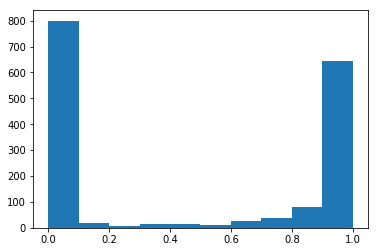

In [133]:
plt.hist(pred_probs[:,0]);

In [134]:
target_class_idx = learn.data.classes.index('off')
target_class_idx

0

In [135]:
preds = (pred_probs[:,target_class_idx] > 0.5).astype(int)
preds

array([1, 1, 1, 1, ..., 1, 1, 1, 0])

**Test set accuracy**

In [136]:
(preds == labels).mean()

0.9590361445783132

# Test Off Sample API

In [137]:
from requests import post
import json
import base64
from pathlib import Path
import shutil
from PIL import Image
import io

In [138]:
image_paths = path_label_df.path.values
len(image_paths)

1660

In [175]:
# chunk_size = 32
# chunk_n = len(image_paths) // chunk_size + 1
# image_path_chunks = [image_paths[i*chunk_size:(i+1)*chunk_size] for i in range(chunk_n)]

In [176]:
def make_chunk_gen(items, chunk_size):
    chunk_n = (len(items) - 1) // chunk_size + 1
    chunks = [items[i * chunk_size:(i + 1) * chunk_size] for i in range(chunk_n)]
    for image_path_chunk in chunks:
        yield image_path_chunk

In [140]:
len([len(ch) for ch in image_path_chunks])

52

In [182]:
import threading
from functools import wraps
from time import sleep

# api_url = 'http://EC2Co-EcsEl-YRBQ515NL1PR-1223156817.eu-west-1.elb.amazonaws.com/off-sample/predict'
# api_endpoint = 'http://localhost:9876/off-sample'
api_endpoint = 'http://off-sample-api-load-balancer-630496755.eu-west-1.elb.amazonaws.com/off-sample'

def retry_on_error(num_retries=3):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            for i in range(num_retries):
                try:
                    return func(*args, **kwargs)
                except Exception:
                    delay = random.uniform(2, 2**(i + 2))
                    thread_name = threading.currentThread().getName()
                    print((f'[{thread_name}] Off-sample API error on attempt {i + 1}. '
                           f'Retrying after {delay:.1f} seconds...'))
                    sleep(delay)
            # Last attempt, don't catch the exception
            return func(*args, **kwargs)

        return wrapper

    return decorator

@retry_on_error()
def predict_chunk(image_path_chunk):
    base64_images = []
    for fp in image_path_chunk:
        with open(fp, 'rb') as f:
            content = base64.b64encode(f.read()).decode()
            base64_images.append(content)
    doc = {
        'images': [{'content': content} for content in base64_images]
    }
    
    resp = post(url=api_endpoint + '/predict', json=doc)
    if resp.status_code == 200:
        chunk_preds = resp.json()['predictions']
    else:
        raise Exception(resp)
    return chunk_preds

#### Test API Synchronously 

In [81]:
# predict_chunk(image_path_chunks[0])

In [85]:
# %%time
# predictions = []
# for image_path_chunk in image_path_chunks:
#     chunk_preds = predict_chunk(image_path_chunk)
#     predictions.extend(chunk_preds)

In [83]:
len(predictions)

64

In [84]:
predictions[:5]

[{'prob': 0.9252671599388123, 'label': 'off'},
 {'prob': 0.9698059558868408, 'label': 'off'},
 {'prob': 0.9950131773948669, 'label': 'off'},
 {'prob': 0.9864990711212158, 'label': 'off'},
 {'prob': 0.001479876460507512, 'label': 'on'}]

#### Test API Asynchronously

In [183]:
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [185]:
%%time
predictions = []
with ThreadPoolExecutor(2) as pool:
    for ch_preds in pool.map(predict_chunk, image_path_chunks):
        predictions.extend(ch_preds)

CPU times: user 385 ms, sys: 44.9 ms, total: 430 ms
Wall time: 8min 43s


In [147]:
len(predictions)

1660

In [148]:
preds = [p['prob'] > 0.5 for p in predictions]

**Test set accuracy**

In [149]:
(preds == labels).mean()

0.9590361445783132